## Section 9: Prepare the Transformer Model for Training

In this section we will set up the training parameters for the model.

According to the paper Attention Is All You Need, we will be using Adam as the optimizer but with a custom learning rate schedule.

The learning rate schedule is the plan for adjusting the learning rate during the training process. As is commonly done, we will start the schedule with a large learning rate and gradually decrease it over time. This helps the network converge on the optimal solution faster in the beginning of training, and then fine-tune the solution as training continues. 

It is implemented as follows:

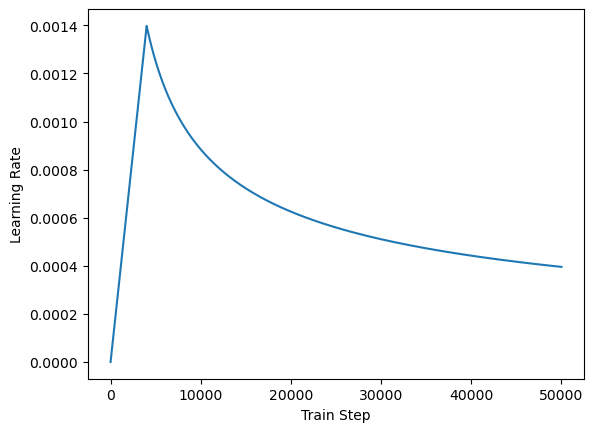

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
 
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)
 
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
 
    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config


key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
 
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()    

plt.savefig("section09_figure01_learningRateSchedule.jpg")

The learning rate schedule is designed in such a way that it learns slowly at the beginning but accelerates as it learns. This helps because the model is totally random at the beginning, and you cannot even trust the output much. But as you train the model enough, the result should be sufficiently sensible and thus you can learn faster to help convergence.

Next, you also need to define the loss metric and accuracy metric for training. This model is special because you need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements. Borrow the implementation from TensorFlow’s tutorial Neural machine translation with a Transformer and Keras (https://www.tensorflow.org/text/tutorials/transformer)

In [17]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

With all these, you can now compile your Keras model as follows:

In [18]:
import pickle

vocab_size_eng = 10000
vocab_size_ita = 20000
seq_length = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1

with open("key_values.pickle", "wb") as fp:
    key_vals = {
      "vocab_size_eng": vocab_size_eng,
      "vocab_size_ita": vocab_size_ita,
      "seq_len": seq_length,
      "num_layers": num_layers,
      "num_heads": num_heads,
      "key_dim": key_dim,
      "ff_dim": ff_dim,
      "dropout": dropout
    }
    pickle.dump(key_vals, fp)
      

with open("learning_rate_schedule.pickle", "wb") as fp:
    pickle.dump(CustomSchedule, fp) # save class definition

schedule = CustomSchedule(key_dim=100, warmup_steps=4000)
with open("customSchedule.pickle", "wb") as fp:
    pickle.dump(schedule, fp) # save instance of the class

In [14]:
import numpy as np
import tensorflow as tf
from transformer_building_blocks import PositionalEmbedding, encoder, decoder, transformer

model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim,
                    vocab_size_eng, vocab_size_ita, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

with open("optimizer_values.pickle", "wb") as fp:
    optim_vals = {
      "beta_1": 0.9,
      "beta_2": 0.98,
      "epsilon": 1e-9
    }
    pickle.dump(optim_vals, fp)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

Moreover, when you look at the diagram of the transformer model and your implementation here, you should notice the diagram shows a softmax layer at the output, but we omitted that. The softmax... expand

finally, we add the *transformer* to the *transformer_building_blocks.py* file.
We also create the *learning_params.py* file in which  we save *CustomSchedule*, *masked_loss*, and *masked_accuracy*.